# Tree-Based Model Cost-Based Learning

In [1]:
import os
import tempfile
from datetime import datetime
from io import BytesIO, StringIO
from pathlib import Path

import boto3
import botocore.exceptions
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import sklearn.ensemble as skens
import sklearn.metrics as mtr
import sklearn.model_selection as mds
import sklearn.preprocessing as pp
import xgboost as xgb
from dotenv import load_dotenv
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import sklearn.utils as skut

In [2]:
PROJ_ROOT = Path.cwd().parent

In [3]:
assert load_dotenv(dotenv_path=PROJ_ROOT.parent / '.env')

In [4]:
import cc_churn.visualization as vzu
from cc_churn.evaluation import evaluate_model
from cc_churn.scoring import get_scorers
from cc_churn.tuning import tune_threshold_cv

## About

Machine Learning (ML) model training using tree-based models.

### Outputs

Same as in `04_model_development__cost_sensitive_learning__linear_models`.

## User Inputs

In [5]:
# R2 data bucket details
bucket_name = 'cc-churn-splits'
# # name of train data key (file) in private R2 bucket
r2_key_train = 'train_data.parquet.gzip'
# # name of validation data key (file) in private R2 bucket
r2_key_val = 'validation_data.parquet.gzip'
# # name of test data key (file) in private R2 bucket
r2_key_test = 'test_data.parquet.gzip'

# datatypes for categorical columns
dtypes_categoricals = {
    "gender": 'string[pyarrow]',
    "marital_status": 'string[pyarrow]',
    "income_category": 'string[pyarrow]',
    "card_category": 'string[pyarrow]',
    "education_level": 'string[pyarrow]',
}

# EDA
threshold_correlation = 0.55

# model development
# # model validation
n_cv_folds = 5
primary_metric_val = 'prauc'
metrics_list_val = [primary_metric_val, 'f2', 'recall', 'rocauc']
# # model evaluation
primary_metric_eval = 'f2'
metrics_list_eval = [primary_metric_eval, 'recall']
threshold_overfit = 5

label = 'is_churned'

# costs
# # revenue from transactions (bank earns #% of transaction volume)
interchange_rate = 0.02
# # revenue from revolving balance (~20% interest)
apr = 0.18
# # fee revenue from credit card exposure (modeled from card type)
card_fees = {"Blue": 0, "Silver": 50, "Gold": 100, "Platinum": 200}
tenure_years = 3
discount = 0.9
# # percentage of churners who can be convinced to stay (i.e. success rate
# # of saving a churning customer)
success_rate = 0.40
# # cost of intervention to get a single customer to not churn (discounts,
# # call center time, retention offers, etc.)
intervention_cost = 50

multiplier = (1 - discount**tenure_years) / (1 - discount)

In [6]:
account_id = os.getenv('ACCOUNT_ID')
access_key_id = os.getenv('ACCESS_KEY_ID_USER2')
secret_access_key = os.getenv('SECRET_ACCESS_KEY_USER2')

scorers_val = get_scorers(metrics_list_val)
scorers_eval = get_scorers(metrics_list_eval)

s3_client = boto3.client(
    's3',
    endpoint_url=f'https://{account_id}.r2.cloudflarestorage.com',
    aws_access_key_id=access_key_id,
    aws_secret_access_key=secret_access_key,
    region_name='auto'
)

In [7]:
def pandas_read_parquet_r2(bucket_name, r2_key):
    """Read parquet file from private R2 bucket."""
    s3_object = s3_client.get_object(Bucket=bucket_name, Key=r2_key)
    df = pd.read_parquet(
        BytesIO(s3_object['Body'].read()), dtype_backend='pyarrow'
    )
    return df


def export_df_to_r2(df, bucket_name, r2_key):
    """Export DataFrame to file in private R2 bucket, if not present."""
    try:
        s3_client.head_object(Bucket=bucket_name, Key=r2_key)
        print(f"Key {r2_key} already exists in bucket {bucket_name}")
    except botocore.exceptions.ClientError as e:
        if e.response["Error"]["Code"] == "404":
            print(f"Key {r2_key} does not exist in bucket {bucket_name}")
            buffer = BytesIO()
            df.to_parquet(
                buffer,
                index=False,
                engine='pyarrow',
                compression='gzip',
            )
            response = s3_client.put_object(
                Bucket=bucket_name, Key=r2_key, Body=buffer.getvalue()
            )
            assert response['ResponseMetadata']['HTTPStatusCode'] == 200
            print(f"Exported {len(df):,} rows to key: {r2_key}")
        elif e.response["Error"]["Code"] == "403":
            print(f"Access denied to bucket {bucket_name} or key {r2_key}")
        else:
            print(f"An unexpected error occurred: {e}")

## Load Data

### Data for Model Validation

Load the training data

In [ ]:
%%time
df_train = (
    pandas_read_parquet_r2(bucket_name, r2_key_train)
    .astype(dtypes_categoricals)
)
print(f"Loaded {len(df_train):,} rows of training data")
with pd.option_context('display.max_columns', None):
    display(df_train.head())

### Data for Model Evaluation

Load the validation data

In [ ]:
%%time
df_val = (
    pandas_read_parquet_r2(bucket_name, r2_key_val)
    .astype(dtypes_categoricals)
)
print(f"Loaded {len(df_val):,} rows of validation data")
with pd.option_context('display.max_columns', None):
    display(df_val.head())

Get the combined training+validation data split

In [ ]:
%%time
df_train_val = pd.concat([df_train, df_val], ignore_index=True)
print(f"Obtained {len(df_train_val):,} rows of training+validation data")
with pd.option_context('display.max_columns', None):
    display(df_train_val.head())

Load the test data

In [ ]:
%%time
df_test = (
    pandas_read_parquet_r2(bucket_name, r2_key_test)
    .astype(dtypes_categoricals)
)
print(f"Loaded {len(df_test):,} rows of test data")
with pd.option_context('display.max_columns', None):
    display(df_test)

## Separate Features from Target

In [12]:
# model validation
X_train = df_train.drop(columns=[label])
y_train = df_train[label]

X_val = df_val.drop(columns=[label])
y_val = df_val[label]

# model evaluation
X_train_val = df_train_val.drop(columns=[label])
y_train_val = df_train_val[label]

X_test = df_test.drop(columns=[label])
y_test = df_test[label]

# model inference
X_all = pd.concat([X_train, X_val, X_test])
y_all = pd.concat([y_train, y_val, y_test])

## EDA

Show the class imbalance

In [13]:
display(y_train.value_counts(normalize=True).to_frame())

,proportion
is_churned,
0,0.8393
1,0.1607


Use the class imbalance to get the class_weights for cost-sensitive learning

In [14]:
# utilize inverse of class distribution (class imbalance ratio)
class_weights_train = skut.class_weight.compute_class_weight(
    class_weight="balanced",
    classes=y_train.squeeze().unique().to_numpy(),
    y=y_train.squeeze().to_numpy(),
)
class_weights_train = {c:float(w) for w, c in zip(class_weights_train, [0,1])}

class_weights_train

{0: 0.5957345971563981, 1: 3.1113861386138613}

Get the correlation between all numerical features and show combinations of features that are correlated

In [15]:
%%time
df_corr = X_train[
    list(X_train.select_dtypes(['int64', 'double']))
].corr()

# Filter for high correlations by absolute value
high_corr_pairs = []
for i in range(len(df_corr.columns)):
    for j in range(i + 1, len(df_corr.columns)):
        col1 = df_corr.columns[i]
        col2 = df_corr.columns[j]
        corr_value = df_corr.loc[col1, col2]
        if abs(corr_value) > threshold_correlation:
            high_corr_pairs.append(
                {'feat_1': col1, 'feat_2': col2, 'correlation': corr_value}
            )
df_correlated_features = (
    pd.DataFrame.from_records(high_corr_pairs)
    .sort_values(by=['correlation'], ascending=False, ignore_index=True)
)
display(df_correlated_features)

,feat_1,feat_2,correlation
0,credit_limit,avg_open_to_buy,0.995847
1,total_revolv_bal,avg_utilization_ratio,0.629318


CPU times: user 6.63 ms, sys: 0 ns, total: 6.63 ms
Wall time: 6.33 ms


Show the number of unique values in all categorical and ordinal features

In [16]:
(
    X_train[list(X_train.select_dtypes(['string']))]
    .nunique()
    .reset_index()
    .rename(columns={'index': 'feature_name', 0: 'num_unique_values'})
)

,feature_name,num_unique_values
0,gender,2
1,education_level,7
2,marital_status,4
3,income_category,6
4,card_category,4


## Model Validation

### Feature Selection

Define ordinal, categorical and numerical features, excluding correlated features

In [17]:
ordinal_features = [
    'income_category',
    'education_level',
]
categorical_features = [
    # 'card_category',
    'marital_status',
]
numeric_features = [
    # 'customer_age',
    # # 'dependent_count',
    'months_on_book',
    'num_products',
    'months_inactive_12_mon',
    'contacts_count_12_mon',
    'total_revolv_bal',
    # 'avg_open_to_buy',
    'total_amt_chng_q4_q1',
    # 'total_trans_amt',
    'total_trans_ct',
    'total_ct_chng_q4_q1',
    # 'avg_utilization_ratio',
]
# did not find that ordinals or categoricals improved scores
features = numeric_features#+ordinal_features+categorical_features

Verify no correlated features have been selected

In [18]:
for _, row in df_correlated_features.iterrows():
    feats_corr = row[['feat_1', 'feat_2']].tolist()
    try:
        assert len(
            set(feats_corr).intersection(set(features))
        ) <= 1
    except AssertionError as e:
        print(feats_corr)

Define a feature preprocessing pipeline

In [19]:
numeric_transformer = Pipeline(
    steps = [('scaler', pp.MinMaxScaler())]
)
categorical_transformer = Pipeline(
    steps=[
        ("ohe", pp.OneHotEncoder(handle_unknown="ignore", drop='if_binary'))
    ]
)
ordinal_transformer = Pipeline(
    steps=[
        (
            "oe",
            pp.OrdinalEncoder(
                categories=[
                    [
                        'Unknown',
                        'Less than $40K',
                        '$40K - $60K',
                        '$60K - $80K',
                        '$80K - $120K',
                        '$120K +'
                    ],
                    [
                        'Unknown', 
                        'Uneducated', 
                        'High School', 
                        'College', 
                        'Graduate', 
                        'Post-Graduate', 
                        'Doctorate'
                    ],
                ],
                handle_unknown="use_encoded_value",
                dtype=np.float64,
                unknown_value=np.nan,
            )
        ),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        # # did not find these two transformers improved scores
        # ("ord", ordinal_transformer, ordinal_features),
        # ("cat", categorical_transformer, categorical_features),
    ],
    remainder='drop',
    verbose_feature_names_out=False,
    n_jobs=-1,
)
clf_inputs = dict(
    features=features,
    preprocessor=preprocessor,
    X_train=X_train,
    y_train=y_train,
    sample_weights=None,
)

Define models to be compared, using the `class_weights` set to `"balanced"`

In [20]:
models = {
    'LogisticRegression_imbalanced': LogisticRegression(
        class_weight=None, random_state=42, n_jobs=-1
    ),
    'LogisticRegression': LogisticRegression(
        class_weight='balanced', random_state=42, n_jobs=-1
    ),
    'HistGradientBoostingClassifier': skens.HistGradientBoostingClassifier(
        # # VERSION 1
        # max_depth=3,
        # max_bins=255,
        # l2_regularization=0.25,
        # learning_rate=0.1,
        # max_iter=250,
        # class_weight=class_weights,
        # random_state=42,
        # # VERSION 2
        max_depth=3,
        l2_regularization=0.25,
        class_weight='balanced',
        random_state=42,
    ),
    'RandomForestClassifier': skens.RandomForestClassifier(
        n_estimators=300,
        max_depth=3,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1,
    ),
    'XGBClassifier': xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        gamma=20,
        max_depth=0,
        eta=0.05,
        min_child_weight=15,
        scale_pos_weight=class_weights_train[1]/class_weights_train[0],
        random_state=42,
        n_jobs=-1,
    ),
    'Ensemble__VotingClassifier': skens.VotingClassifier(
        estimators=[
            (
                'lr',
                LogisticRegression(
                    class_weight='balanced', random_state=42, n_jobs=-1
                ),
            ),
            (
                'hbc', skens.HistGradientBoostingClassifier(
                    max_depth=3,
                    l2_regularization=0.25,
                    class_weight='balanced',
                    random_state=42,
                ),
            ),
            (
                'rf', skens.RandomForestClassifier(
                    n_estimators=300,
                    max_depth=3,
                    class_weight='balanced',
                    random_state=42,
                    n_jobs=-1,
                ),
            ),
            (
                    'xgb', xgb.XGBClassifier(
                    objective='binary:logistic',
                    eval_metric='logloss',
                    # # VERSION 1
                    # gamma=15,
                    # max_depth=0,
                    # # min_child_weight=7,
                    # # VERSION 2
                    gamma=20,
                    max_depth=0,
                    eta=0.05,
                    min_child_weight=15,
                    scale_pos_weight=(
                        class_weights_train[1]/class_weights_train[0]
                    ),
                    random_state=42,
                    n_jobs=-1,
                ),
            ),
        ],
        voting='soft',
    )
}

In [21]:
%%time
cv_results_tuned_models = {
    model_name_param: tune_threshold_cv(
        preprocessor,
        model,
        model_name_param,
        n_cv_folds,
        scorers_val,
        primary_metric_val,
        features,
        X_train,
        y_train,
    )
    for model_name_param, model in models.items()
    if 'Dummy' not in model_name_param
}

(LogisticRegression_imbalanced) Start: 2025-10-14 15:16:46...done at 2025-10-14 15:16:48 (1.92 s).
(LogisticRegression) Start: 2025-10-14 15:16:48...done at 2025-10-14 15:16:50 (1.77 s).
(HistGradientBoostingClassifier) Start: 2025-10-14 15:16:50...done at 2025-10-14 15:16:52 (2.09 s).
(RandomForestClassifier) Start: 2025-10-14 15:16:52...done at 2025-10-14 15:16:56 (4.49 s).
(XGBClassifier) Start: 2025-10-14 15:16:56...done at 2025-10-14 15:16:57 (0.95 s).
(Ensemble__VotingClassifier) Start: 2025-10-14 15:16:57...done at 2025-10-14 15:17:03 (5.55 s).
CPU times: user 1.65 s, sys: 21.9 ms, total: 1.67 s
Wall time: 16.8 s


**Notes**

1. Standard K-Fold (`KFold()`) cross-validation leads to misleading results because the class distribution might not be maintained across folds. This can result in some folds having very few or no samples of the minority class (`is_churned = True`), leading to biased performance estimates. To address this, `StratifiedKFold()` is recommended, since it ensures that each fold maintains approximately the same class distribution as the original dataset, providing more reliable performance estimates.
2. `StratifiedKFold()` is used with the following parameters
   - `shuffle=True` shuffles the data before splitting, providing more robust split
   - `random_state` is set to ensure reproducibility

Verify that expected numerical features were used in threshold tuning cross-validation

In [22]:
%%time
if [t[0] for t in preprocessor.transformers] == ['num']:
    # expected features
    preprocessor.fit(X_train[features])
    feats_expected = preprocessor.get_feature_names_out()
    
    # features used by each model during threshold tuning
    for model_name_param in list(cv_results_tuned_models):
        for k in cv_results_tuned_models[model_name_param]['estimator']:
            assert k.feature_names_in_.tolist() == feats_expected.tolist()

CPU times: user 6.43 ms, sys: 74 μs, total: 6.5 ms
Wall time: 14.1 ms


Show the following per fold of outer CV

1. best threshold determined from inner CV and used in outer-CV
2. outer CV scores

In [ ]:
df_cv_scores_outer = (
    # best thresholds determined from inner CV and used in outer CV
    pd.DataFrame.from_records(
        [
            {
                'model': m,
                'cv_fold_outer': k,
                'threshold': float(est.best_threshold_),
            }
            for m, v in cv_results_tuned_models.items()
            for k, est in enumerate(v["estimator"], 1)
        ]
    )
    .merge(
        # scores from outer CV
        (
            pd.concat(list(cv_results_tuned_models.values()))
            .assign(cv_fold_outer=lambda df: df.index+1)
            .drop(columns=['estimator'])
            .rename(columns={"model_name": "model", 'fit_time': "train_time"})
            .reset_index(drop=True)
        ),
        on=['model', 'cv_fold_outer'],
        how='left',
    )
)
df_cv_scores_outer

Get mean cross-validation scores using

1. default threshold for baseline models
2. best threshold for ML models

In [24]:
df_cv_scores_all = (
    df_cv_scores_outer
    .drop(columns=['cv_fold_outer'])
    .groupby(['model'], as_index=False)
    .mean()
    .convert_dtypes(dtype_backend='pyarrow')
    .assign(
        pct_diff=lambda df: (
            (
                df[f'train_{primary_metric_val}']
                -df[f'test_{primary_metric_val}']
            ).abs()/df[f'train_{primary_metric_val}']*100
        ),
        is_overfit=lambda df: (
            (
                df[f'train_{primary_metric_val}']
                > df[f'test_{primary_metric_val}']
            )
            .astype('bool[pyarrow]')
        ),
        is_overfit_significant=lambda df: (
            (
                (df['is_overfit'] == True)
                & (df['pct_diff'] > threshold_overfit)
            ).astype('bool[pyarrow]')
        ),
    )
    .sort_values(
        by=[f'test_{primary_metric_val}'], ascending=[False], ignore_index=True
    )
)
(
    df_cv_scores_all
    .style
    .set_properties(
        subset=['model']+[f'test_{m}' for m in metrics_list_val],
        **{'background-color': 'yellow', 'color': 'black'}
    )
    .set_properties(
        subset=[f'train_{m}' for m in metrics_list_val],
        **{'background-color': 'teal', 'color': 'white'}
    )
    .set_properties(
        subset=['is_overfit_significant'],
        **{'background-color': 'darkred', 'color': 'white'}
    )
)

,model,threshold,train_time,score_time,test_prauc,train_prauc,test_f2,train_f2,test_recall,train_recall,test_rocauc,train_rocauc,pct_diff,is_overfit,is_overfit_significant
0,HistGradientBoostingClassifier,0.754410,0.959054,0.025208,0.636820,0.686566,0.742475,0.783551,0.726733,0.770545,0.847537,0.871481,7.245619,True,True
1,Ensemble__VotingClassifier,0.665158,5.128225,0.087478,0.601252,0.642142,0.737400,0.768425,0.731683,0.763119,0.843946,0.862270,6.367789,True,True
2,XGBClassifier,0.728473,0.837158,0.022606,0.599207,0.660790,0.737019,0.787948,0.731683,0.785891,0.843661,0.873751,9.319655,True,True
3,RandomForestClassifier,0.643604,4.203809,0.076358,0.530342,0.557128,0.631444,0.653761,0.604950,0.626733,0.785129,0.797608,4.807813,True,False
4,LogisticRegression_imbalanced,0.332606,0.608115,0.020708,0.462527,0.474420,0.634018,0.646993,0.633663,0.647525,0.782140,0.789639,2.506701,True,False
5,LogisticRegression,0.721596,0.618770,0.020606,0.457164,0.467764,0.628436,0.637220,0.627723,0.635891,0.778885,0.784178,2.265949,True,False


**Observations**

1. Except for `LogisticRegression`, all tree-based models are over-fitting by approximately 5-9%. For the best (tree-based) models, this degree of over-fitting is significant based on our pre-defined threshold of 5%, which was defined in `threshold_overfit`. For the purposes of this version of the analysis, we will assume this is acceptable and no further model tuning is performed to reduce this to less than 5%.
2. The model performance using the primary metric for model validation (`prauc`) suggests
   - tree-based models out-perform the linear model (`LogisticRegression`)
   - improvement in model performance is warranted

Get best ML model and best decision threshold, based on mean CV scores

In [25]:
best_estimator = (
    df_cv_scores_all
    .nlargest(1, f'test_{primary_metric_val}')
    ['model']
    .squeeze()
)
best_estimator_threshold = (
    df_cv_scores_all
    .query(f"model == '{best_estimator}'")
    ['threshold']
    .squeeze()
)
assert '_imbalanced' not in best_estimator

Show distribution of best thresholds during threshold tuning (inner) cross-validation, for best ML model

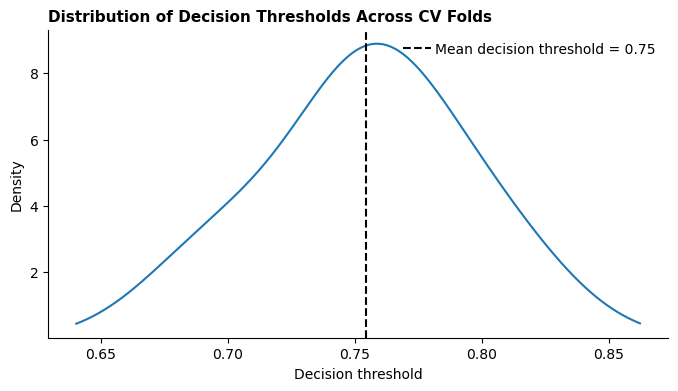

In [26]:
decision_thresholds = pd.Series(
    [
        est.best_threshold_
        for est in cv_results_tuned_models[best_estimator]["estimator"]
    ],
)

fig, ax = plt.subplots(figsize=(8, 4))
ax = decision_thresholds.plot.kde(ax=ax)
ax.axvline(
    decision_thresholds.mean(),
    color="k",
    linestyle="--",
    label=f"Mean decision threshold = {decision_thresholds.mean():.2f}",
)
ax.set_xlabel("Decision threshold")
ax.legend(
    loc="upper right",
    frameon=False,
    handletextpad=0.3,
)
ax.spines[['right', 'top']].set_visible(False)
_ = ax.set_title(
    "Distribution of Decision Thresholds Across CV Folds",
    loc='left',
    fontweight='bold',
    fontsize=11,
)

**Observations**

1. From plotting the best decision threshold values determined from the inner cross-validation scores, the best decision threshold is taken as the mean value (0.75, see dashed line above) of the distribution.

### Evaluate Model Performance on Validation Split

Get ML model predictions of the data which was not seen during model selection and threshold tuning (validation data)

In [ ]:
%%time
_, df_val_pred = evaluate_model(
    preprocessor,
    models[best_estimator],
    best_estimator,
    X_train,
    y_train,
    X_val,
    y_val,
    scorers_eval,
    'balanced',
    primary_metric=primary_metric_eval,
    threshold_overfit=threshold_overfit,
    threshold_scoring=best_estimator_threshold,
)
with pd.option_context('display.max_columns', None):
    display(df_val_pred)

## Model Evaluation

Model evaluation uses the test data split.

Model evaluation is performed to evaluate the performance of the model on unseen data (test split). The best model is trained on the combined training and validation data. It is then used the make predictions of the test split and these predictions are scored. See [phase 3 from the metrics section of the project scope](https://github.com/edesz/credit-card-churn/blob/main/references/01_proposal.md#final-choice-of-metrics) for details about the choice of metric for model evaluation.

### Evaluate Model Performance on Test Split

Get ML model predictions of the data which was not seen during model validation and threshold tuning (test data)

In [28]:
%%time
df_scores, df_test_pred = evaluate_model(
    preprocessor,
    models[best_estimator],
    best_estimator,
    X_train_val,
    y_train_val,
    X_test,
    y_test,
    scorers_eval,
    'balanced',
    primary_metric=primary_metric_eval,
    threshold_overfit=threshold_overfit,
    threshold_scoring=best_estimator_threshold,
)
(
    pd.concat(
        [
            (
                df_cv_scores_all
                .nlargest(1, f'test_{primary_metric_eval}')
                .drop(
                    columns=(
                        ['train_time', 'score_time']
                        +[
                            f"{s}_{m}"
                            for m in [metrics_list_val[0], metrics_list_val[-1]]
                            for s in ['train', 'test']
                        ]
                    )
                )
                .assign(split='validation')
            ),
            (
                df_scores
                .assign(split='test', threshold=best_estimator_threshold)
                .rename(
                    columns={
                        f"pct_diff_{primary_metric_eval}": "pct_diff",
                        f"is_overfit_{primary_metric_eval}": "is_overfit",
                        f"is_overfit_significant_{primary_metric_eval}": (
                            "is_overfit_significant"
                        ),
                    }
                )
            ),
        ],
        ignore_index=True,
    )
    .style
    .set_properties(
        subset=['model']+[f'test_{m}' for m in metrics_list_eval],
        **{'background-color': 'yellow', 'color': 'black'}
    )
    .set_properties(
        subset=[f'train_{m}' for m in metrics_list_eval],
        **{'background-color': 'teal', 'color': 'white'}
    )
    .set_properties(
        subset=[f"is_overfit_significant"],
        **{'background-color': 'darkred', 'color': 'white'}
    )
)

CPU times: user 280 ms, sys: 25.7 ms, total: 306 ms
Wall time: 152 ms


,model,threshold,test_f2,train_f2,test_recall,train_recall,pct_diff,is_overfit,is_overfit_significant,split
0,HistGradientBoostingClassifier,0.754410,0.742475,0.783551,0.726733,0.770545,7.245619,True,True,validation
1,HistGradientBoostingClassifier,0.754410,0.735995,0.788099,0.715942,0.776911,6.611368,True,True,test


**Observations**

1. The scores on the test data are in good agreement with scores on the validation data using ML metrics.
2. The observed overfitting is approximately 6.6%, which is close to that observed during model validation (approximately 7.2%). In the test data, this degree of over-fitting is again significant based on our pre-defined threshold of 5%, which was defined in `threshold_overfit`. As with the validation scores, we assume this over-fitting is acceptable for this iteration of the analysis.

### Class Imbalance

Get the true and predicted class imbalance for the test data

In [29]:
%%time
df_true_pred_class_imbalance = (
    (
        df_test_pred['y_pred']
        .value_counts(normalize=True)
        .rename('predicted')
        .to_frame()
    )
    .merge(
        (
            df_test_pred['is_churned']
            .value_counts(normalize=True)
            .rename('true')
            .to_frame()
        ),
        left_index=True,
        right_index=True,
    )
)
df_true_pred_class_imbalance.index = df_true_pred_class_imbalance.index.map(
    {0: 'No Churn', 1: 'Churn'}
)
churn_true = df_true_pred_class_imbalance.loc['Churn']['true']
churn_pred = df_true_pred_class_imbalance.loc['Churn']['predicted']
df_true_pred_class_imbalance

CPU times: user 2.76 ms, sys: 949 μs, total: 3.71 ms
Wall time: 3.37 ms


,predicted,true
y_pred,,
No Churn,0.861331,0.83946
Churn,0.138669,0.16054


**Observations**

1. The class imbalance in the test split is approximately the same as that in the training split (~84%:16%).
2. It is reassuring that the true and predicted class imbalance are close to each other.

The class imbalance in the validation and test data is shown below

In [30]:
%%time
df_val_test_true_class_imbalance = (
    df_val_pred['is_churned']
    .value_counts(normalize=True)
    .rename('validation')
    .to_frame()
    .merge(
        df_test_pred['is_churned'].value_counts(normalize=True).rename('test').to_frame(),
        left_index=True,
        right_index=True,
        how='left',
    )
)
df_val_test_true_class_imbalance.index = df_val_test_true_class_imbalance.index.map(
    {0: 'No Churn', 1: 'Churn'}
)
df_val_test_true_class_imbalance

CPU times: user 2.14 ms, sys: 966 μs, total: 3.11 ms
Wall time: 2.78 ms


,validation,test
is_churned,,
No Churn,0.839338,0.83946
Churn,0.160662,0.16054


**Notes**

1. It is reassuring that the class imbalances are nearly equivalent between the validation and test splits. Patterns seen in during model validation should not be impacted by changes of the class imbalance during model evaluation.

Show the class imbalance and distribution of prediction probabilities for the test data

CPU times: user 57.4 ms, sys: 1.96 ms, total: 59.4 ms
Wall time: 58.4 ms


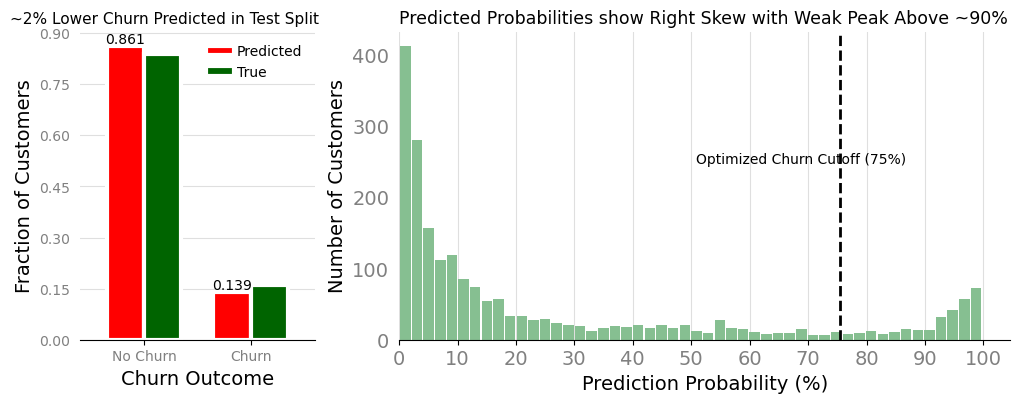

In [31]:
%%time
vzu.plot_class_imbalance_proba_distribution(
    df_class_imbalance=df_true_pred_class_imbalance.rename(columns=str.title),
    df_probabilities=(df_test_pred['y_pred_proba']*100),
    ptitle1='~2% Lower Churn Predicted in Test Split',
    title1_xloc=-0.3,
    ptitle2=(
        'Predicted Probabilities show Right Skew with Weak Peak Above ~90%'
    ),
    vline_label=f'Optimized Churn Cutoff ({best_estimator_threshold*100:.0f}%)',
    decision_threshold=best_estimator_threshold,
    subfigure_width_ratios=[1.15, 3],
    fig_size=(12, 4)
)

**Observations**

1. As expected from the predicted class imbalance, the distribution of predicted probabilities is right-skewed and a small fraction of customers have a predicted probability above 50% (the tuned classification decision threshold).

## Model Inference

Prepare model for inference using live data in production.

In [ ]:
%%time
_, df_all_pred = evaluate_model(
    preprocessor,
    models[best_estimator],
    best_estimator,
    X_all,
    y_all,
    X_all,
    y_all,
    scorers_eval,
    'balanced',
    primary_metric=primary_metric_eval,
    threshold_overfit=threshold_overfit,
    threshold_scoring=best_estimator_threshold,
)
with pd.option_context('display.max_columns', None):
    display(df_all_pred)

## Export Project Deliverables to Private R2 Bucket

Get the current timestamp in the format `YYmmdd_HHMMSS`

In [33]:
curr_timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

### Data Files with Churn Predictions

The following will be appended to the validation split (`df_val`) and test split (`df_test`)

1. ML model predictions (in the `y_pred` column)
2. ML model prediction probabilities (in the `y_pred_proba` column)
3. name of best model (in the `model_name` column)
4. best decision threshold ( in the `best_decision_threshold` column)

#### Validation Split

Append to the validation split (`df_val`)

In [ ]:
%%time
df_val_pred = (
    df_val_pred
    .assign(best_decision_threshold=best_estimator_threshold)
    .astype(
        {
            "model_name": 'category',
            'best_decision_threshold': 'float64[pyarrow]',
        }
    )
    .astype({k: 'category' for k in list(dtypes_categoricals)})
)
print(f"Got {len(df_val_pred):,} rows of validation split predictions")
with pd.option_context('display.max_columns', None):
    display(df_val_pred.head())
df_val_pred.info(memory_usage='deep')

Next, export to a file in the R2 bucket with the following file name format `validation_predictions__<best-model-name>__<current-timestamp-YYmmdd_HHMMSS>.parquet.gzip`

In [35]:
%%time
export_df_to_r2(
    df_val_pred,
    bucket_name,
    (
        f"validation_predictions__{best_estimator.lower()}__"
        f"{curr_timestamp}.parquet.gzip"
    ),
)

#### Test Split

Append to the test split (`df_test`)

In [ ]:
%%time
df_test_pred = (
    df_test_pred
    .assign(best_decision_threshold=best_estimator_threshold)
    .astype(
        {
            "model_name": 'category',
            'best_decision_threshold': 'float64[pyarrow]',
        }
    )
    .astype({k: 'category' for k in list(dtypes_categoricals)})
)
print(f"Got {len(df_test_pred):,} rows of validation split predictions")
with pd.option_context('display.max_columns', None):
    display(df_test_pred.head())
df_test_pred.info(memory_usage='deep')

Next, export to a file in the R2 bucket with the following file name format `test_predictions__<best-model-name>__<current-timestamp-YYmmdd_HHMMSS>.parquet.gzip`

In [37]:
# %%time
# export_df_to_r2(
#     df_test_pred,
#     bucket_name,
#     (
#         f"test_predictions__{best_estimator.lower()}__"
#         f"{curr_timestamp}.parquet.gzip"
#     ),
# )

#### All Available Data

Append to all available data

In [ ]:
%%time
df_all_pred = (
    df_all_pred
    .assign(best_decision_threshold=best_estimator_threshold)
    .astype(
        {
            "model_name": 'category',
            'best_decision_threshold': 'float64[pyarrow]',
        }
    )
    .astype({k: 'category' for k in list(dtypes_categoricals)})
)
print(f"Got {len(df_all_pred):,} rows of predictions on all available data")
with pd.option_context('display.max_columns', None):
    display(df_all_pred.head())
df_all_pred.info(memory_usage='deep')

### Best Trained ML Model Object

Define pipeline with best model

In [39]:
pipe_best = Pipeline(
    [
        ("pre", preprocessor),
        ('clf', models[best_estimator]),
    ]
)

#### Trained on Combined Training and Validataion Data (Train+Validation)

Train the best model on the combined training and validation data (`X_train_val` and `y_train_val`)

In [ ]:
%%time
pipe_best.fit(X_train_val[features], y_train_val)

Export to `.joblib` file in R2 bucket

In [41]:
# %%time
# with tempfile.TemporaryFile() as fp:
#     # Dump the object to the in-memory file
#     joblib.dump(pipe_best, fp)

#     # Seek to the beginning of the file before uploading
#     fp.seek(0)

#     # Upload the in-memory file to our team's R2 bucket
#     s3_client.put_object(
#         Body=fp.read(),
#         Bucket=bucket_name,
#         Key=(
#             f"best_model__{best_estimator}__train_val__{curr_timestamp}.joblib"
#         ),
#     )

#### Trained on All Available Data (Train+Validation+Test)

Train the best model on all available data (`X_all` and `y_all`)

In [ ]:
%%time
pipe_best.fit(X_all[features], y_all)

Export to `.joblib` file in R2 bucket

In [43]:
# %%time
# with tempfile.TemporaryFile() as fp:
#     # Dump the object to the in-memory file
#     joblib.dump(pipe_best, fp)

#     # Seek to the beginning of the file before uploading
#     fp.seek(0)

#     # Upload the in-memory file to our team's R2 bucket
#     s3_client.put_object(
#         Body=fp.read(),
#         Bucket=bucket_name,
#         Key=(
#             f"best_model__{best_estimator}__all__{curr_timestamp}.joblib"
#         ),
#     )

In [44]:
# %%time
# df_costs_val, _, _ = costs.get_cost(
#     df_val_pred,
#     best_estimator_threshold,
#     interchange_rate,
#     apr,
#     card_fees,
#     multiplier,
#     success_rate,
#     intervention_cost,
# )
# with pd.option_context('display.max_columns', None):
#     display(df_costs_val)

# vzu.plot_roi_curves(
#     df_costs_val['n'],
#     df_costs_val['cum_true_savings'],
#     df_costs_val['cum_pred_savings'],
#     df_costs_val['ROI_percent'],
#     df_costs_val['ROI_percent_pred'],
#     {},
#     ptitle=(
#         'Excluding initial Noisy Period, ROI is Maximized after Selecting Top '
#         '~190 At-Risk Customers'
#     ),
#     legend_loc='lower right',
#     xlabel=f"Number of Predicted Churners to Contact (Top-N)",
#     ylabel="Expected Net Savings ($)",
#     fig_size=(12, 8),
# )